In [1]:
# %cd /content/drive/My\ Drive/Colab\ Notebooks

In [2]:
## COMP9517 Computer Vision Project 20T2
# code: Main program for the project
#
# Group C:
# Connor Baginski (z5207788)
# Bhumika Singhal (z5234799)
# Rishav Guha (z5294757)
# Amel Johny (z5294308)

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils
from processing import *
from network import Network

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from skimage.filters import meijering

from scipy import ndimage as ndi

from cell_tracking.helpers import fi_list, find_centers, plot_rectangles,find_labels_Phc,find_labels_Fluo,print_tracks,put_text,plot_rectangles_normal
from cell_tracking.pathTracking import PathTracker



def fi_list(path):
    """
    Return a sorted list of filenames in a given path
    """
    return sorted([os.path.join(path, f) for f in os.listdir(path)])

def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title(titleR)
    plt.show(block=True)

def custom_thresh(image):
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] > 0.05:
                image[r,c] = 255
            else:
                image[r,c] = 0

    return image

In [3]:
def detect_DIC():
    pathTracker = PathTracker(cost_threshold = 10)
    bounding_box_list = []
    
    for filename in fi_list('DIC-C2DH-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        # Preprocessing
        image = equalize_clahe(image)
        x = torch.tensor(np.array([image.astype(np.float32)]))
        # Add a "Batch" dimension
        x = x.unsqueeze(0)
        
        # Load CNN models
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        net = Network()
        # TODO: CHANGE TO BEST MODEL
        net.load_state_dict(torch.load("CNN_min_loss_dic.pth", map_location=device))
#         net.load_state_dict(torch.load("CNN_max_score_dic.pth", map_location=device))
        
        with torch.no_grad():
            net.eval()

            # Generate cell mask and markers from image           
            output = net(x)
            markers = (output[0,0] > 0.5).int()
            cell_mask = (output[0,1] > 0.5).int()
            
#             # Plot output images
#             plt.imshow(image, cmap='gray')
#             plt.title("Input")
#             plt.show()
            
#             plot_two_images(cell_mask, markers, "Cell Mask", "Markers")
            
            # Postprocessing
            ws_labels = get_ws_from_markers(markers.numpy(), cell_mask.numpy(), 12)
            bound_box = get_bound_box_from_ws(image, ws_labels)
#             pimg(ws_labels)

            #find Center
            centers, boundingBoxes, circular, is_circular = find_centers(ws_labels,image)
#           pimg(ws_labels)
            number_of_cells_in_frame = len(centers)
            put_text(image, 10,50,"No of cells : {}".format(number_of_cells_in_frame))
            #update tracker with new positions
#             print(centers)
            pathTracker.update(image,centers, circular, is_circular, boundingBoxes)
            bounding_box_list.append(boundingBoxes)
            plot_rectangles_normal(image,boundingBoxes)
#             print tracks
            print_tracks(image, pathTracker, number_of_cells_in_frame)
#             plt.imshow(bound_box, cmap='gray')
#             plt.title("Cells with bounding box.")
#             plt.show()
    image_counter = 0
    for filename in fi_list('DIC-C2DH-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        # Preprocessing
        image = equalize_clahe(image)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        plot_rectangles(image,bounding_box_list,pathTracker.mito_frames, image_counter)
        image_counter +=1

    selected_cell = pathTracker.get_cell_from_center(3,np.array([488, 150]))
    print(selected_cell.positions, selected_cell.added_in_frame)
    
    print(get_cell_speed_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_distance_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_net_distance_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_confinement_ratio_at_frame(pathTracker, 4, np.array([173, 22])))
    
    return

In [4]:
def detect_Fluo():
    pathTracker = PathTracker(cost_threshold = 10)
    bounding_box_list = []
    for filename in fi_list('Fluo-N2DL-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        # Threshold at value of 129
        thresh = cv2.threshold(image, 129, 255, cv2.THRESH_BINARY)[1]
        distance = ndi.distance_transform_edt(thresh)
        local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
                                labels=thresh)
        markers, _ = ndi.label(local_maxi)
        ws_labels = watershed(-distance, markers, mask=thresh)
        
        #TODO: cite/recode following
        # loop over the unique labels returned by the Watershed
        # algorithm
        for label in np.unique(ws_labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue

            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape, dtype="uint8")
            mask[ws_labels == label] = 255

            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)

            # draw a rectangle enclosing the object
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
#             cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
        plt.gray()
        plt.imshow(thresh, cmap='gray')
        plt.show()
#         plt.imshow(image)
#         plt.show()
        centers, boundingBoxes = find_centers(ws_labels, image)
        number_of_cells_in_frame = len(centers)
        put_text(image, 10,50,"No of cells : {}".format(number_of_cells_in_frame))
        #update tracker with new positions
#             print(centers)
        pathTracker.update(image,centers)
        plot_rectangles_normal(image,boundingBoxes)
        
        # print tracks
        print_tracks(image, pathTracker, number_of_cells_in_frame)
    image_counter = 0
    for filename in fi_list('Fluo-N2DL-HeLa/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        # Preprocessing
        image = equalize_clahe(image)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        plot_rectangles(image,bounding_box_list,pathTracker.mito_frames, image_counter)
        image_counter +=1

    selected_cell = pathTracker.get_cell_from_center(3,np.array([488, 150]))
    print(selected_cell.positions, selected_cell.added_in_frame)
    
    print(get_cell_speed_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_distance_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_net_distance_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_confinement_ratio_at_frame(pathTracker, 4, np.array([173, 22])))
    return

def detect_PhC():
    
    pathTracker = PathTracker(cost_threshold = 10)
    bounding_box_list = []
    for filename in fi_list(r'PhC-C2DL-PSC/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        
        # Preprocessing
        image = equalize_clahe(image)
        x = torch.tensor(np.array([image.astype(np.float32)]))
        # Add a "Batch" dimension
        x = x.unsqueeze(0)
        
        # Load CNN models
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        net = Network()
        # TODO: CHANGE TO BEST MODEL
        net.load_state_dict(torch.load("CNN_min_loss_phc.pth", map_location=device))
#         net.load_state_dict(torch.load("CNN_max_score_phc.pth", map_location=device))
        
        with torch.no_grad():
            net.eval()

            # Generate cell mask and markers from image           
            output = net(x)

            markers = (output[0,0] > 0.5).int()
            cell_mask = (output[0,1] > 0.5).int()
            
#             # Plot output images
#             plt.imshow(image, cmap='gray')
#             plt.title("Input")
#             plt.show()
            
#             plot_two_images(cell_mask, markers, "Cell Mask", "Markers")
            
            # Postprocessing
            ws_labels = get_ws_from_markers(markers.numpy(), cell_mask.numpy(), 0)
            bound_box = get_bound_box_from_ws(image, ws_labels)
#             pimg(ws_labels)

            #find Center
            centers, boundingBoxes, circular, is_circular = find_centers(ws_labels,image)
            number_of_cells_in_frame = len(centers)
            
           
 #update tracker with new positions
            pathTracker.update(image,centers, circular, is_circular, boundingBoxes)
            bounding_box_list.append(boundingBoxes)
            plot_rectangles_normal(image,boundingBoxes)
            put_text(image, 10,50,"No of cells : {}".format(number_of_cells_in_frame))
#             print tracks
            print_tracks(image, pathTracker, number_of_cells_in_frame)
            
#             plt.imshow(bound_box, cmap='gray')
#             plt.title("Cells with bounding box.")
#             plt.show()
    image_counter = 0
    for filename in fi_list(r'PhC-C2DL-PSC/Sequence 1'):
        if not filename.endswith(".tif"):
            continue
        print(filename)
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        # Preprocessing
        image = equalize_clahe(image)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        plot_rectangles(image,bounding_box_list,pathTracker.mito_frames, image_counter)
        image_counter +=1

    selected_cell = pathTracker.get_cell_from_center(3,np.array([488, 150]))
    print(selected_cell.positions, selected_cell.added_in_frame)

    print(get_cell_speed_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_distance_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_net_distance_at_frame(pathTracker, 4, np.array([173, 22])))
    print(get_cell_confinement_ratio_at_frame(pathTracker, 4, np.array([173, 22])))      
    return
        
#         thresh = cv2.threshold(image, 162, 255, cv2.THRESH_BINARY)[1]
#         kernel = np.ones((4,4),np.uint8)
#         # Perform an erosion followed by dilation opening to remove noise
#         opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
#         distance = ndi.distance_transform_edt(opening)
#         local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)),
#                                 labels=thresh)
#         markers, _ = ndi.label(local_maxi)
#         ws_labels = watershed(-distance, markers, mask=thresh)
        
#         #TODO: cite/recode following
#         # loop over the unique labels returned by the Watershed
#         # algorithm
#         for label in np.unique(ws_labels):
#             # if the label is zero, we are examining the 'background'
#             # so simply ignore it
#             if label == 0:
#                 continue

#             # otherwise, allocate memory for the label region and draw
#             # it on the mask
#             mask = np.zeros(image.shape, dtype="uint8")
#             mask[ws_labels == label] = 255

#             # detect contours in the mask and grab the largest one
#             cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
#                 cv2.CHAIN_APPROX_SIMPLE)
#             cnts = imutils.grab_contours(cnts)
#             c = max(cnts, key=cv2.contourArea)

#             # draw a rectangle enclosing the object
#             x,y,w,h = cv2.boundingRect(c)
#             cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
#             cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
#         plt.imshow(image, cmap='gray')
#         plt.show()
#         plt.imshow(opening, cmap='gray')
#         plt.show()
#         plt.imshow(ws_labels, cmap='gray')
#         plt.show()
#     return

Choose a dataset.
1) DIC-C2DH-HeLa
2) Fluo-N2DL-HeLa
3) PhC-C2DL-PSC
> 3
PhC-C2DL-PSC/Sequence 1\t000.tif


C:\Users\amelj\anaconda3\lib\site-packages\torch\nn\functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
C:\Users\amelj\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1


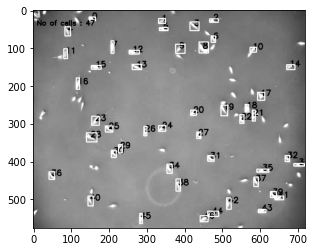

PhC-C2DL-PSC/Sequence 1\t001.tif
2


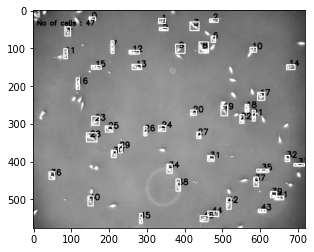

PhC-C2DL-PSC/Sequence 1\t002.tif
3


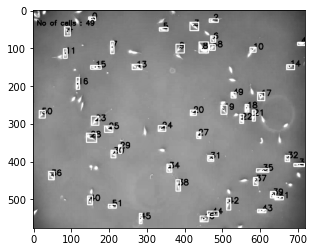

PhC-C2DL-PSC/Sequence 1\t003.tif
4


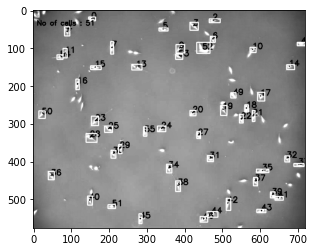

PhC-C2DL-PSC/Sequence 1\t004.tif
5


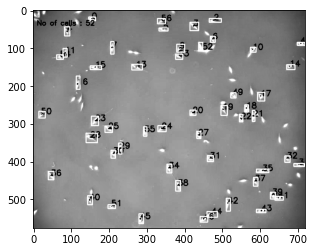

PhC-C2DL-PSC/Sequence 1\t005.tif
6


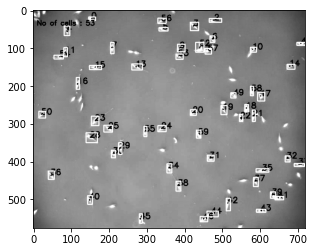

PhC-C2DL-PSC/Sequence 1\t006.tif
7


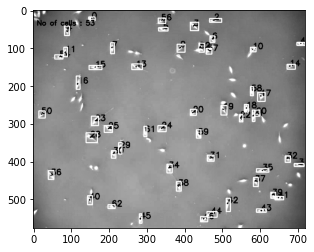

PhC-C2DL-PSC/Sequence 1\t007.tif
8


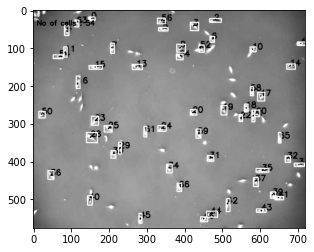

PhC-C2DL-PSC/Sequence 1\t008.tif
9


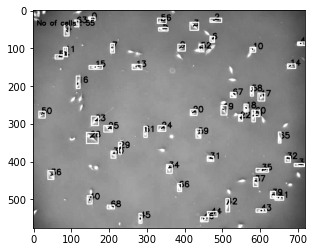

PhC-C2DL-PSC/Sequence 1\t009.tif
10


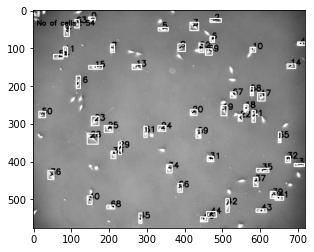

PhC-C2DL-PSC/Sequence 1\t010.tif
11


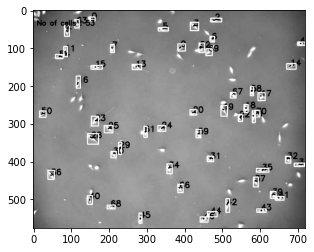

DIC-C2DH-HeLa/Sequence 1\t006.tif


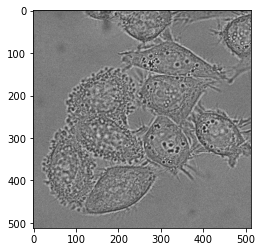

DIC-C2DH-HeLa/Sequence 1\t007.tif


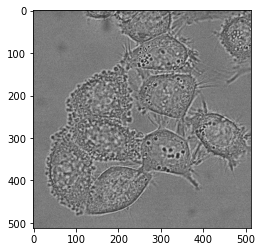

DIC-C2DH-HeLa/Sequence 1\t008.tif


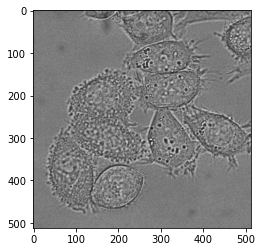

DIC-C2DH-HeLa/Sequence 1\t009.tif


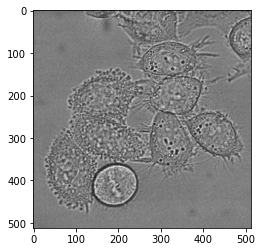

DIC-C2DH-HeLa/Sequence 1\t010.tif


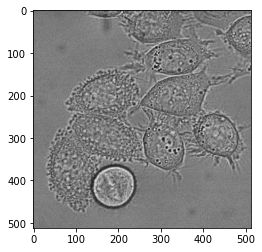

DIC-C2DH-HeLa/Sequence 1\t011.tif


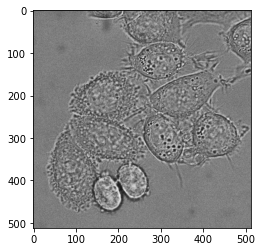

DIC-C2DH-HeLa/Sequence 1\t012.tif


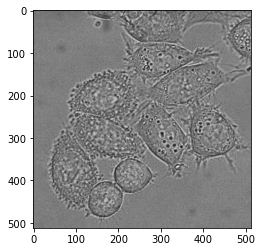

DIC-C2DH-HeLa/Sequence 1\t013.tif


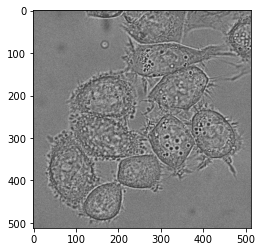

DIC-C2DH-HeLa/Sequence 1\t014.tif


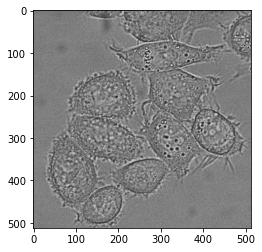

[array([448, 103])] 3
[array([156,  22]), array([156,  22]), array([156,  22]), array([155,  22]), array([155,  22]), array([155,  22])]
0.0
1.0
1.0
1.0


In [5]:
def main():
    select = int(input("Choose a dataset.\n1) DIC-C2DH-HeLa\n2) Fluo-N2DL-HeLa\n3) PhC-C2DL-PSC\n> "))

    if select == 1:
        detect_DIC()
    elif select == 2:
        detect_Fluo()
    elif select == 3:
        detect_PhC()
    else:
        print("Invalid input.")

if __name__ == '__main__':
    main()